# Time Series Breakdown of Retail Sales

**Internship Task 1 – Elevvo Pathways**  
**Author:** Ayesha Nadeem   
**Date:** 10 August 2025  

---

## Introduction

This project focuses on analyzing and forecasting sales data to identify trends, patterns, and future demand.  
The objective is to leverage data analytics techniques to provide accurate sales predictions, enabling better decision-making for business growth. 

The analysis includes:  

- **Identifying seasonal patterns in sales data**  
- **Detecting long-term growth or decline trends**  
- **Comparing different forecasting methods for accuracy**  

Results are evaluated using key performance indicators to ensure reliable and actionable insights.

### Load All CSV's

In [1]:
import pandas as pd

features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Convert Date columns
for df in [features, train, test]:
    df['Date'] = pd.to_datetime(df['Date'])

### Merge Relevant Files

In [2]:
# Merge store info
train_merged = train.merge(stores, on="Store", how="left")

# Merge features
train_merged = train_merged.merge(features, on=["Store", "Date"], how="left")

train_merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


### Handle Missing Values

In [7]:
#Fill missing CPI/Unemployment with forward fill per store
train_merged[['CPI', 'Unemployment']] = (
    train_merged.groupby('Store')[['CPI', 'Unemployment']].ffill().bfill()
)

# Fuel_Price might not need imputation if missing only on non-sales weeks

### Ensure Correct Formatting & Sorting

In [8]:
train_merged['Date'] = pd.to_datetime(train_merged['Date'])
train_merged = train_merged.sort_values(by=['Store', 'Date'])

### Remove Outliers

In [9]:
import numpy as np
Q1 = train_merged['Weekly_Sales'].quantile(0.25)
Q3 = train_merged['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Keep only values within 1.5 * IQR range
train_merged = train_merged[
    ~((train_merged['Weekly_Sales'] < (Q1 - 1.5 * IQR)) | 
      (train_merged['Weekly_Sales'] > (Q3 + 1.5 * IQR)))
]

### Aggregate To Monthly

In [10]:
train_merged = train_merged.set_index('Date')
monthly_sales = train_merged['Weekly_Sales'].resample('M').sum()

/var/folders/y3/f1z_df5s1pl46lm6gnhgz_lc0000gn/T/ipykernel_57627/3655378051.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = train_merged['Weekly_Sales'].resample('M').sum()


### Normalize for trend comparison

In [11]:
train_merged['Sales_Per_Sqft'] = train_merged['Weekly_Sales'] / train_merged['Size']

### Aggregate data for Time Series

In [13]:
# Ensure Date is index
train_merged = train_merged.sort_index()

# Monthly total sales
monthly_sales = train_merged['Weekly_Sales'].resample('M').sum()

# Breakdown by department
monthly_by_dept = (
    train_merged.groupby('Dept')['Weekly_Sales']
    .resample('M').sum().unstack(level=0)
)

# Breakdown by store type
monthly_by_type = (
    train_merged.groupby('Type')['Weekly_Sales']
    .resample('M').sum().unstack(level=0)
)

/var/folders/y3/f1z_df5s1pl46lm6gnhgz_lc0000gn/T/ipykernel_57627/2547198729.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = train_merged['Weekly_Sales'].resample('M').sum()
/var/folders/y3/f1z_df5s1pl46lm6gnhgz_lc0000gn/T/ipykernel_57627/2547198729.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').sum().unstack(level=0)
/var/folders/y3/f1z_df5s1pl46lm6gnhgz_lc0000gn/T/ipykernel_57627/2547198729.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').sum().unstack(level=0)


### Trend + Moving Avg

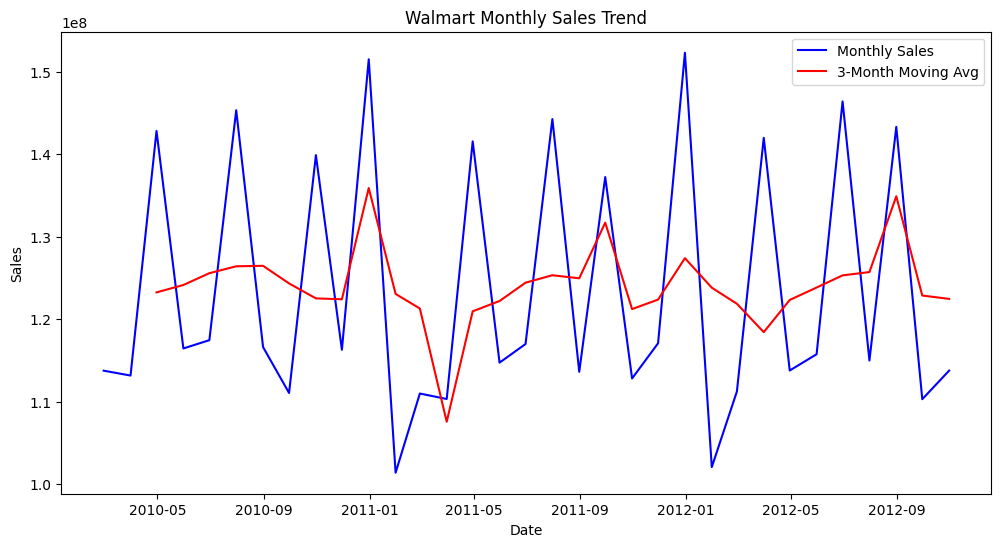

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(monthly_sales, label="Monthly Sales", color='blue')
plt.plot(monthly_sales.rolling(3).mean(), label="3-Month Moving Avg", color='red')
plt.title("Walmart Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

### Seasonal Pattern

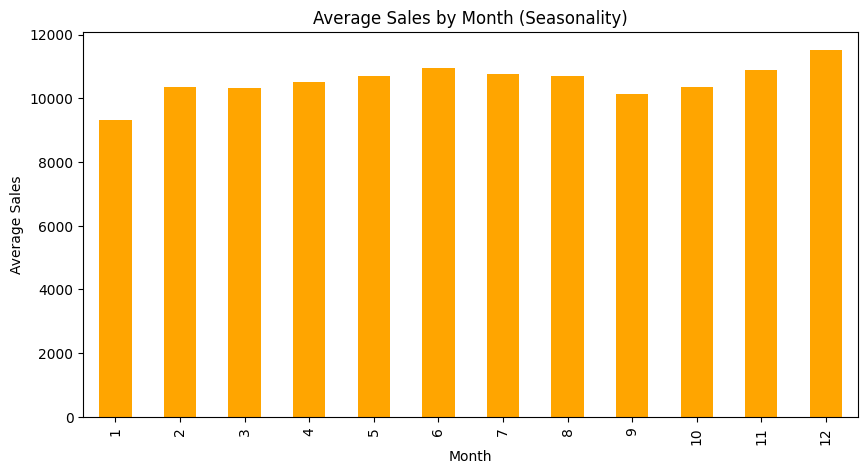

In [15]:
seasonal = train_merged.groupby(train_merged.index.month)['Weekly_Sales'].mean()

plt.figure(figsize=(10,5))
seasonal.plot(kind='bar', color='orange')
plt.title("Average Sales by Month (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()

### Breakdown by Product & Region

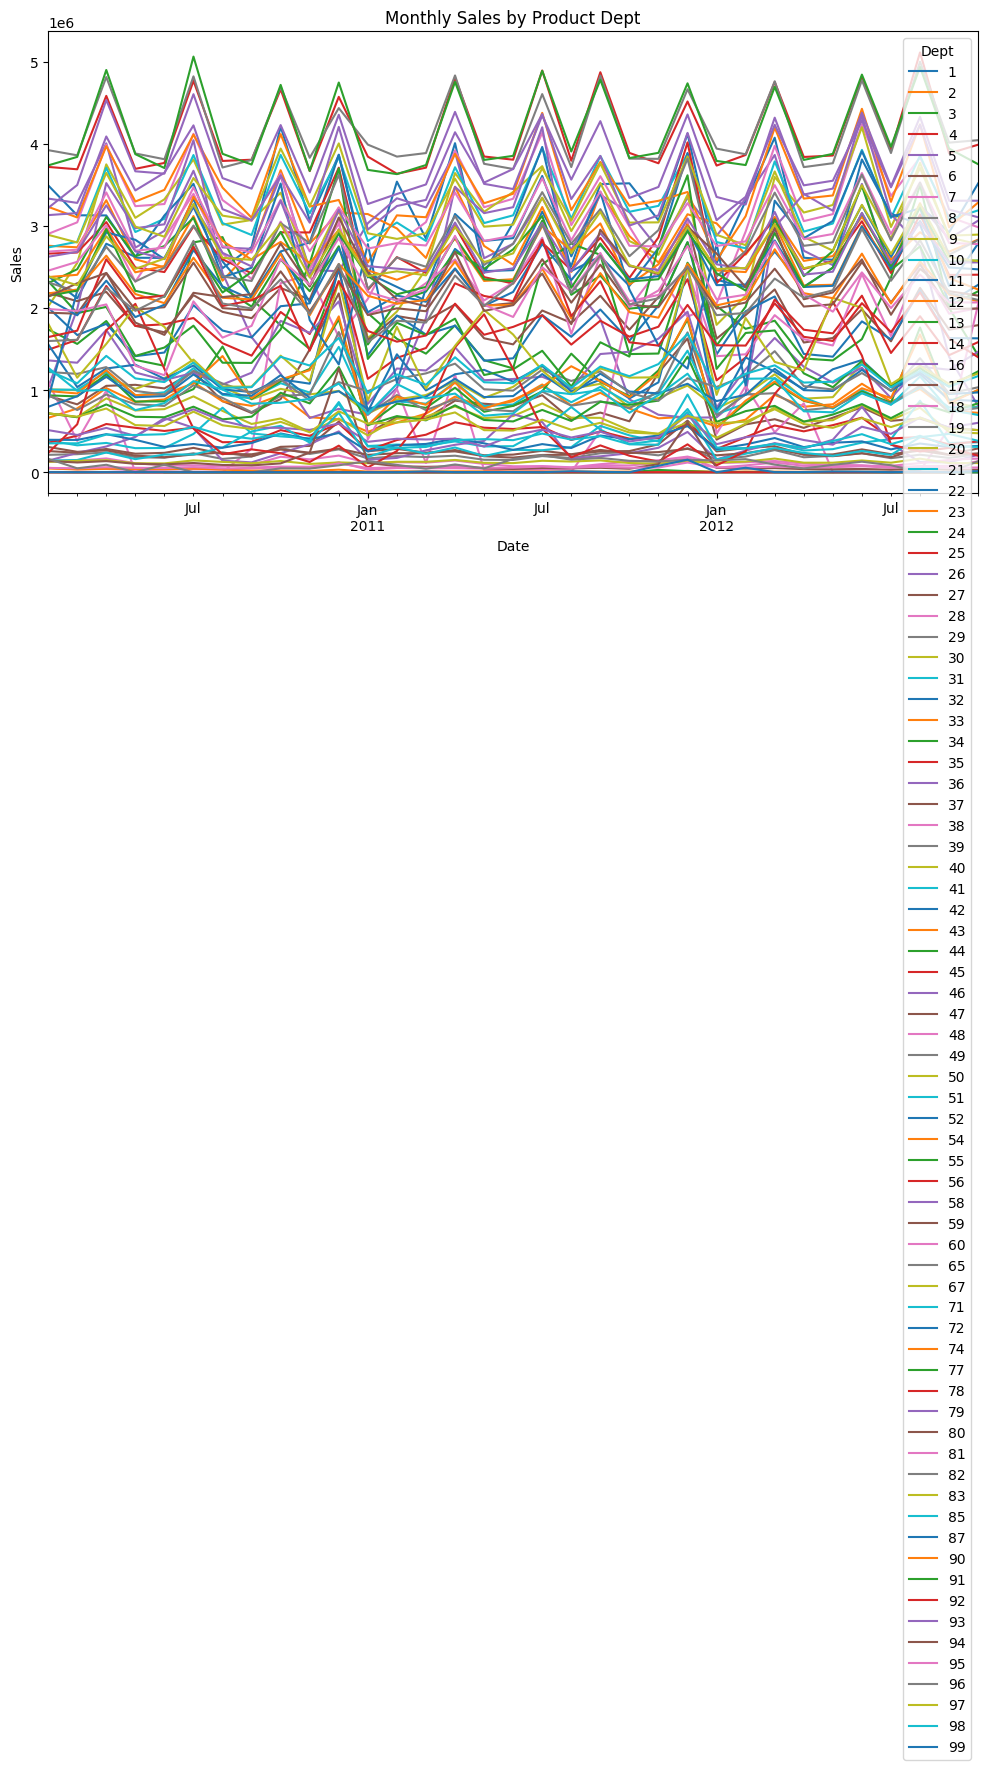

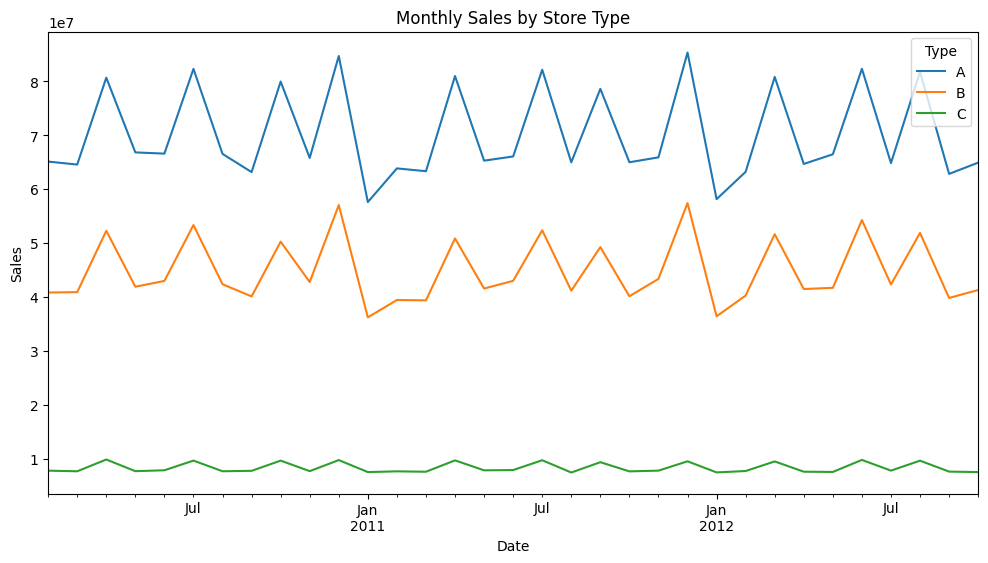

In [16]:
# Product (Dept) trends
monthly_by_dept.plot(figsize=(12,6), title="Monthly Sales by Product Dept")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Store Type trends
monthly_by_type.plot(figsize=(12,6), title="Monthly Sales by Store Type")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

### Simple Forecast

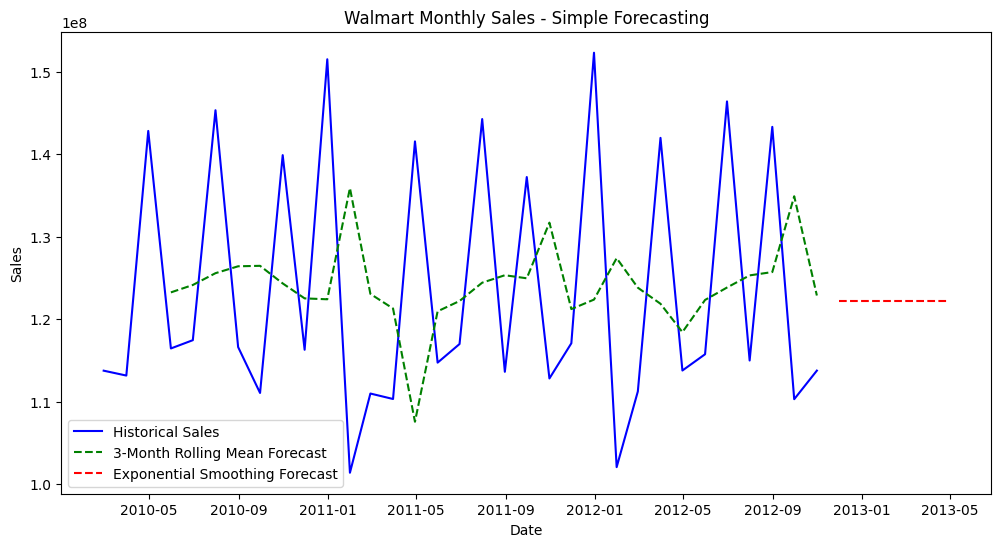

In [19]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# 1️⃣ Rolling Mean Forecast
n = 3  # window size in months
rolling_forecast = monthly_sales.rolling(window=n).mean().shift(1)

# 2️⃣ Exponential Smoothing Forecast
model = SimpleExpSmoothing(monthly_sales).fit(smoothing_level=0.2, optimized=False)
exp_forecast = model.forecast(6)  # next 6 months

# 📊 Plot both forecasts
plt.figure(figsize=(12,6))
plt.plot(monthly_sales, label="Historical Sales", color='blue')
plt.plot(rolling_forecast, label=f"{n}-Month Rolling Mean Forecast", linestyle='--', color='green')
plt.plot(exp_forecast, label="Exponential Smoothing Forecast", linestyle='--', color='red')
plt.title("Walmart Monthly Sales - Simple Forecasting")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()